In [19]:
## Import basic modules and routines
from __future__ import division, absolute_import, print_function

Simulating Atmosphere
====

This notebook treats about the simulation of atmosphere-like signal, that correlated signal both in time and spatially. We start first by simulating white noise at the level of detector timestream, and then we add the correlated part:

$$\begin{equation}
n(t) = n^{w}(t) + n^{corr}(t).
\end{equation}$$

The correlated part is based on an empirical model in frequency domain (power spectrum density, or PSD, of the timestream):

$$\begin{equation}
C(f) = A \Big[ 1 + \Big( \dfrac{f}{f_0} \Big)^{\alpha} \Big],
\end{equation}$$

where $A$ is some normalisation amplitude for the atmospherical fluctuations, $f_0$ is the knee frequency at which correlated noise stops being significant compared to the white noise, and $\alpha$ is the value of the slope (typically negative). The correlated part of the timestream is then obtained by taking the inverse Fourier transform of this PSD (its square root to be precise).

To take into account the fact that atmosphere is evolving over time, we assume a correlation length in time (typically 5min) over which the atmosphere signal is constant. A group of detectors will see the same signal, but with a different amplitude. We assume atmosphere is unpolarised, so bolometers from the same pair will see exactly the same signal. We compute the PSD over this period of time, and generate 1/f noise. At the end of this period, we re-generate new phases and we draw a new realisation of atmosphere, and so on.

To take into account the fact that atmosphere correlates several detectors in the focal plane, we draw several "clouds". All detectors seeing the same cloud will have the same signal shape (with eventually different amplitude).

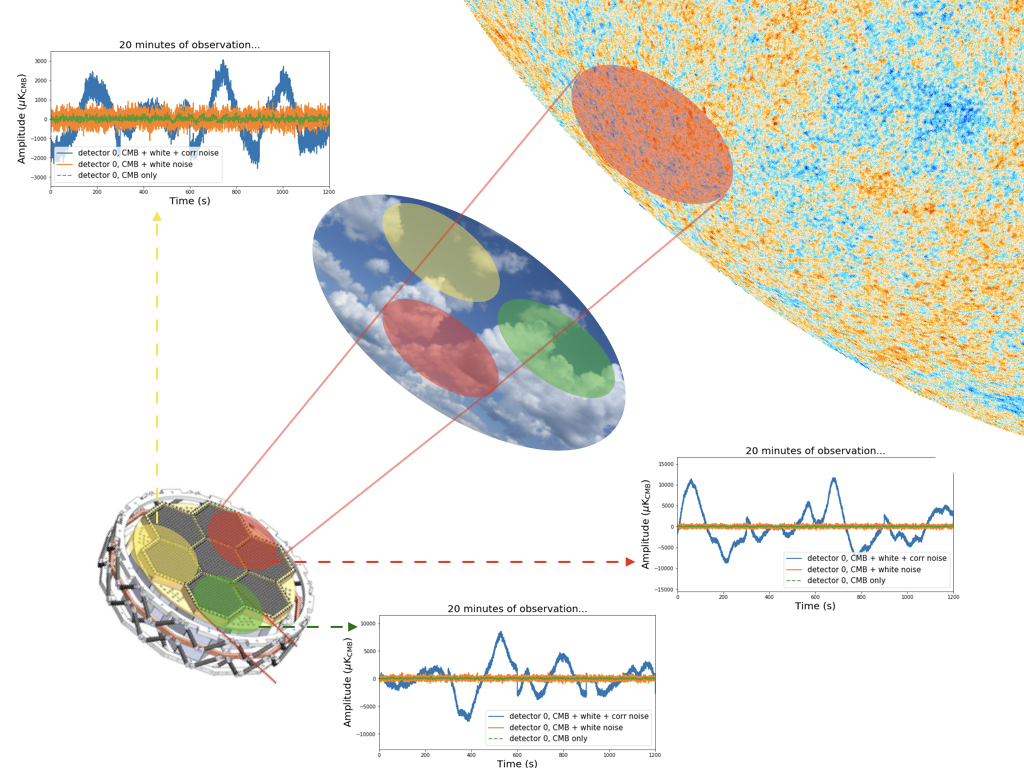

In [18]:
from IPython.display import Image
Image(filename='../data/correlated_noise.jpeg')

**Possible improvements**

This naive model can be easily improved to be more realistic and still fast to run:
* Add spatial correlation length (i.e. simulate several different clouds passing by the focal plane at any given time).
* Add wind speed information. The effect of wind speed is to increase or decrease the spatial correlation length (high speed = less correlation between detectors).
* ...

In [1]:
## In case you did not install properly the library 
## or didn't update your bashrc. (Do it later!)
import os
path_to_s4cmb = '../../s4cmb'
os.sys.path.insert(0, os.path.realpath(path_to_s4cmb))

import healpy as hp
import pylab as pl
import numpy as np

## Import modules and routines from s4cmb
from s4cmb.input_sky import HealpixFitsMap

from s4cmb.instrument import Hardware

from s4cmb.scanning_strategy import ScanningStrategy

from s4cmb.tod import TimeOrderedDataPairDiff
from s4cmb.tod import OutputSkyMap
from s4cmb.tod import partial2full
from s4cmb.tod import psdts

from s4cmb.systematics import step_function_gen
from s4cmb.systematics import linear_function_gen

try:
    from tqdm import *
except ImportError:
    tqdm = lambda x: x

Flow is the following: sky + instrument + scanning strategy --> map2tod --> inject noise --> tod2map.

Initialise our instrument, scanning strategy and input maps as seen in the Day 1 lectures. 

In [2]:
## Instrument
inst = Hardware(ncrate=4, ndfmux_per_crate=1,
                nsquid_per_mux=1, npair_per_squid=16,
                fp_size=60., fwhm=3.5, 
                beam_seed=58347, projected_fp_size=3., pm_name='5params',
                type_hwp='CRHWP', freq_hwp=2., angle_hwp=0., verbose=False)

## Input maps
nside = 512
path_to_cls = '../../s4cmb/s4cmb/data/test_data_set_lensedCls.dat'
sky_in = HealpixFitsMap(path_to_cls, do_pol=True, 
                        fwhm_in=inst.beam_model.fwhm, nside_in=nside, 
                        map_seed=5843787, verbose=False, 
                        no_ileak=False, no_quleak=False)

## Scanning strategy
scan = ScanningStrategy(nces=12, start_date='2013/1/1 00:00:00',
                        telescope_longitude='-67:46.816',
                        telescope_latitude='-22:56.396', telescope_elevation=5200.,
                        name_strategy='deep_patch', sampling_freq=8., sky_speed=0.4,
                        ut1utc_fn='../../s4cmb/s4cmb/data/ut1utc.ephem', 
                        language='fortran')
scan.run()

Let's now generate our TOD from our input sky, instrument, and scanning strategy We will use the difference of pairs of detectors to reconstruct the polarisation (no demodulation). We will also inject instrument noise in time-domain.
Once we will have the timestreams, we will reconstruct our maps on a sky patch of width 130 deg at a resolution nside = 512.

In [3]:
## Time-domain Noise level in [u]K.sqrt(s) for the whole array for one CES.
## Careful the units has to be the same as
## the input map! Note also that it corresponds to the polarisation level.
## This corresponds roughly to 50 uk.arcmin 
## = 1 year of obs, 20% efficiency, 5% of the sky observed.
array_noise_level = 22.

## Correlated noise parameters
## Numbers are based on real observations.
nclouds = 10 ## Number of clouds, that is number of correlated region in the focal plane
corrlength = 300 ## time correlation in seconds
alpha = -4 ## slope
f0 = 0.5 ## knee frequency in Hz
amp_atm = 1. ## normalisation for the amplitude of fluctuations

## Freeze initial seed, and define seeds for all scans
state_for_gain = np.random.RandomState(0)
seeds_for_gain = state_for_gain.randint(0, 1e6, scan.nces)

state_for_noise = np.random.RandomState(3)
seeds_for_noise = state_for_noise.randint(0, 1e6, scan.nces)

## Loop over scans
for CESnumber in range(scan.nces):
    ## Note that we specify that we want to map pairs
    ## one-by-one by setting mapping_perpair to True. This is 
    ## very useful if you have no det-to-det correlations and 
    ## you want to save memory by ot storing all timestreams
    ## in the memory.
    tod = TimeOrderedDataPairDiff(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=130.,
        array_noise_level=array_noise_level,
        array_noise_seed=seeds_for_noise[CESnumber],
        mapping_perpair=True)
    
    tod_corr = TimeOrderedDataPairDiff(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=130.,
        array_noise_level=array_noise_level,
        array_noise_seed=seeds_for_noise[CESnumber],
        nclouds=nclouds,
        f0=f0,
        alpha=alpha,
        amp_atm=amp_atm,
        corrlength=corrlength,
        mapping_perpair=True)
    
    ## Just for visualisation we also compute the result without contamination
    tod_perfect = TimeOrderedDataPairDiff(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=130.,
        array_noise_level=0,
        array_noise_seed=seeds_for_noise[CESnumber],
        mapping_perpair=True)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky = OutputSkyMap(
            projection=tod.projection, 
            nside=tod.nside_out, 
            obspix=tod.obspix)
        
        sky_corr = OutputSkyMap(
            projection=tod.projection, 
            nside=tod.nside_out, 
            obspix=tod.obspix)
        
        sky_perfect = OutputSkyMap(
            projection=tod.projection, 
            nside=tod.nside_out, 
            obspix=tod.obspix)
        
    ## Scan input map to get TODs
    ## Do it pair-by-pair to save memory for large runs.
    for pair in tqdm(tod.pair_list):
        d = np.array([tod.map2tod(det) for det in pair])
        d_corr = np.array([tod_corr.map2tod(det) for det in pair])
        d_perfect = np.array([tod_perfect.map2tod(det) for det in pair])
        
        ## Project TOD to maps
        tod.tod2map(d, sky)
        tod_corr.tod2map(d_corr, sky_corr)
        tod_perfect.tod2map(d_perfect, sky_perfect)

  0%|          | 0/64 [00:00<?, ?it/s]

Pixels outside patch boundaries. Your output map will be cropped. To avoid this, increase the parameter width while initialising the TOD.


100%|██████████| 64/64 [00:32<00:00,  1.99it/s]


Let's also have a look at the PSD of 1 detector for 10 minutes of observation:

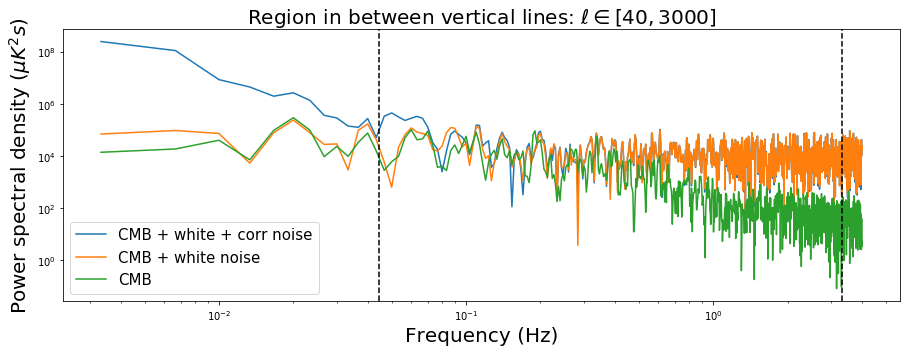

In [4]:
def ell2freq(ell, vscan):
    """
    Rough scaling between timestream frequency and multipole \ell
    given the scan velocity (az speed basically) in deg/s.
    """
    return ell * vscan / 360.

## Average time for a cloud to pass: 2400 samples.s / freq_samp / 60s ~ 5 min.
nts = 2400

fs, psds = psdts(d[0][0: nts] + 0.0, scan.sampling_freq)
fs, psds_corr = psdts(d_corr[0][0: nts] + 0.0, scan.sampling_freq)
fs, psds_perfect = psdts(d_perfect[0][0: nts] + 0.0, scan.sampling_freq)

fig = pl.figure(figsize=(15, 5))
pl.loglog(fs, psds_corr, label='CMB + white + corr noise')
pl.loglog(fs, psds, label='CMB + white noise')
pl.loglog(fs, psds_perfect, label='CMB')
pl.axvline(ell2freq(40, vscan=scan.sky_speed), 
           ls='--', color='black')
pl.axvline(ell2freq(3000, vscan=scan.sky_speed), 
           ls='--', color='black')
pl.title('Region in between vertical lines: $\ell \in [40, 3000]$', fontsize=20)
pl.xlabel('Frequency (Hz)', fontsize=20)
pl.ylabel('Power spectral density ($\mu K^2 s$)', fontsize=20)
pl.legend(fontsize=15)
pl.show()

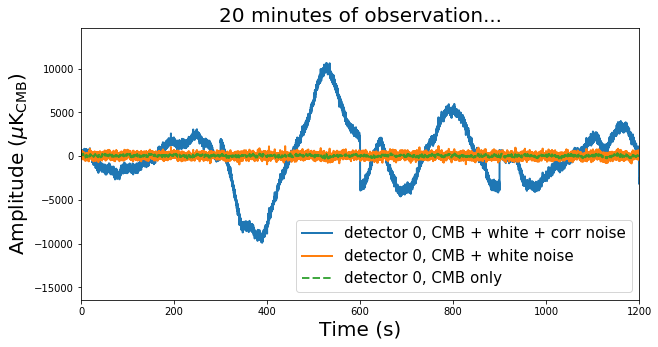

In [12]:
stop = len(d[0])
xaxis = [t/scan.sampling_freq for t in range(0, stop)]

fig, ax = pl.subplots(1, 1, figsize=(10, 5))

ax.plot(xaxis, d_corr[0][0:stop], label='detector 0, CMB + white + corr noise', lw=2)
ax.plot(xaxis, d[0][0:stop], label='detector 0, CMB + white noise', lw=2)
ax.plot(xaxis, d_perfect[0][0:stop], 
           label='detector 0, CMB only', 
           ls='--', lw=2, alpha=0.9)

ax.set_ylabel('Amplitude ($\mu$K$_{\\rm CMB}$)', fontsize=20)
ax.set_xlabel('Time (s)', fontsize=20)
ax.set_title('20 minutes of observation...', fontsize=20)

pl.xlim(0, 1200)
pl.legend(fontsize=15)
pl.show()

Let's check the output maps

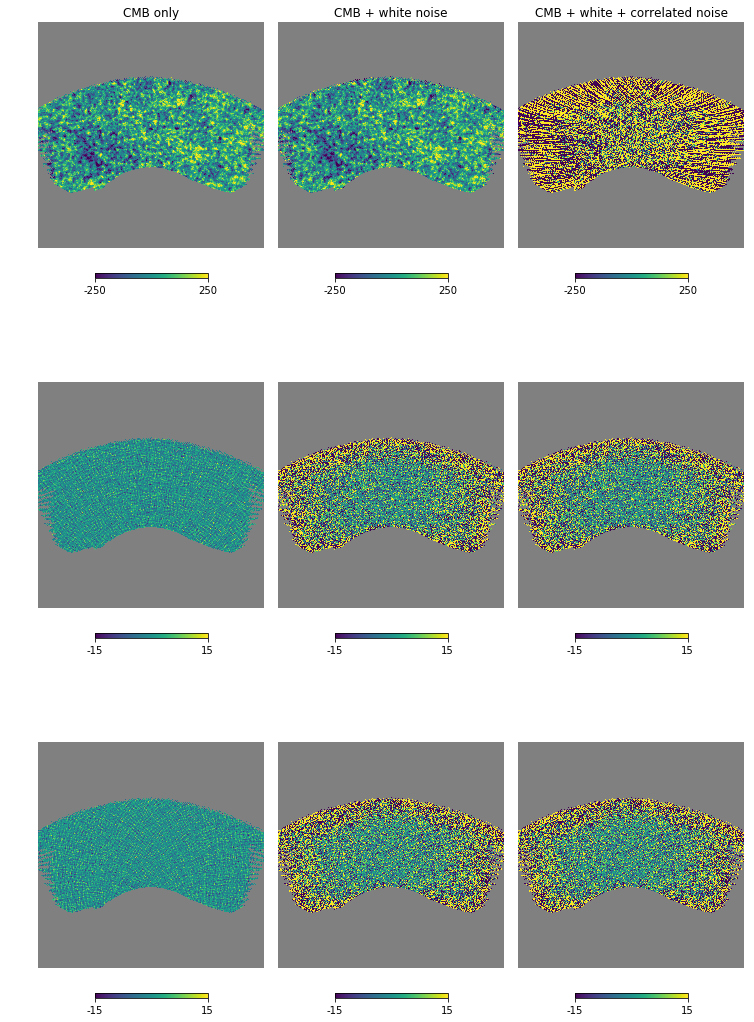

In [13]:
xsize = 700
fig = pl.figure(figsize=(10, 15))

nhit = partial2full(
    sky.nhit, 
    sky.obspix, 
    sky.nside, fill_with=0.0)

## Temperature
sky_out = partial2full(
    sky.get_I(), 
    sky.obspix, 
    sky.nside, fill_with=0.0)
sky_out_corr = partial2full(
    sky_corr.get_I(), 
    sky_corr.obspix, 
    sky_corr.nside, fill_with=0.0)
sky_out_perfect = partial2full(
    sky_perfect.get_I(), 
    sky_perfect.obspix, 
    sky_perfect.nside, fill_with=0.0)

mask = nhit < 1
sky_out[mask] = np.nan
sky_out_perfect[mask] = np.nan
sky_out_corr[mask] = np.nan
hp.gnomview(sky_out_perfect, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=331, 
            title='CMB only', notext=True, min=-250, max=250)
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=332, 
            title='CMB + white noise', notext=True, min=-250, max=250)
hp.gnomview(sky_out_corr, rot=[0, -57.5], 
            xsize=xsize, reso=6.9, sub=333, 
            title='CMB + white + correlated noise', notext=True, min=-250, max=250)

## Stokes Q
sky_out = partial2full(
    sky.get_QU()[0], 
    sky.obspix, 
    sky.nside, fill_with=0.0)
sky_out_corr = partial2full(
    sky_corr.get_QU()[0], 
    sky_corr.obspix, 
    sky_corr.nside, fill_with=0.0)
sky_out_perfect = partial2full(
    sky_perfect.get_QU()[0], 
    sky_perfect.obspix, 
    sky_perfect.nside, fill_with=0.0)

mask = nhit < 10
sky_out[mask] = np.nan
sky_out_perfect[mask] = np.nan
sky_out_corr[mask] = np.nan
hp.gnomview(sky_out_perfect, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=334, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=335,  
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out_corr, rot=[0, -57.5], 
            xsize=xsize, reso=6.9, sub=336, 
            notext=True, title='', min=-15, max=15)

## Stokes U
sky_out = partial2full(
    sky.get_QU()[1], 
    sky.obspix, 
    sky.nside, fill_with=0.0)
sky_out_corr = partial2full(
    sky_corr.get_QU()[1], 
    sky_corr.obspix, 
    sky_corr.nside, fill_with=0.0)
sky_out_perfect = partial2full(
    sky_perfect.get_QU()[1], 
    sky_perfect.obspix, 
    sky_perfect.nside, fill_with=0.0)

mask = nhit < 10
sky_out[mask] = np.nan
sky_out_corr[mask] = np.nan
sky_out_perfect[mask] = np.nan
hp.gnomview(sky_out_perfect, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=337, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=338, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out_corr, rot=[0, -57.5], 
            xsize=xsize, reso=6.9, sub=339, 
            notext=True, title='', min=-15, max=15)
pl.show()

Note that we assume the correlated noise part is unpolarised.